In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
from darts import TimeSeries


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint


from sklearn.preprocessing import MinMaxScaler, RobustScaler
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.dataprocessing.transformers.scaler import Scaler
from darts.dataprocessing import Pipeline



In [34]:
class Config:
    '''
    Class to store config parameters, to circumvent the wandb.config when combining multiple models.
    '''

    def __init__(self):
        self.data = {}

    def __getattr__(self, key):
        if key in self.data:
            return self.data[key]
        else:
            raise AttributeError(f"'Config' object has no attribute '{key}'")

    def __setattr__(self, key, value):
        if key == 'data':
            # Allow normal assignment for the 'data' attribute
            super().__setattr__(key, value)
        else:
            self.data[key] = value

    def __delattr__(self, key):
        if key in self.data:
            del self.data[key]
        else:
            raise AttributeError(f"'Config' object has no attribute '{key}'")

    def __len__(self):
        return len(self.data)

    def keys(self):
        return self.data.keys()

    def values(self):
        return self.data.values()

    def items(self):
        return self.data.items()

    def __getitem__(self, key):
        return self.data[key]

    def __setitem__(self, key, value):
        self.data[key] = value

    @classmethod
    def from_dict(cls, data):
        config = cls()
        for key, value in data.items():
            config[key] = value  # Preserve nested dictionaries without converting
        return config


def prepare_timeseries(
        df,
        datetime_col='datetime',
        tgt_col='Electric_MW',
        cov_cols=['Temperature'],
        num_chunks=4,
        split_pcts=[0.7, 0.2, 0.1],
        config=None,
        pipe=True
):
    # Assuming your DataFrame is named 'df' with columns 'datetime' and 'value'
    tgt_series = TimeSeries.from_dataframe(df, datetime_col, tgt_col)
    cov_series = TimeSeries.from_dataframe(df, datetime_col, cov_cols)

    assert abs(sum(split_pcts)-1.0) < 1e-6, "Split percentages must sum to 1.0"
    assert len(tgt_series) == len(cov_series), "Target and covariate series must be the same length"

    # Define the seasonal chunks
    chunk_length = len(tgt_series) // num_chunks

    # Initialize lists to store the split datasets
    train_tgt_timeseriess = []
    val_tgt_timeseriess = []
    test_tgt_timeseriess = []

    train_cov_timeseriess = []
    val_cov_timeseriess = []
    test_cov_timeseriess = []

    # Split the dataset into chunks and apply split percentages
    for i in range(num_chunks):
        start_index = i * chunk_length
        end_index = (i + 1) * chunk_length

        tgt_chunk = tgt_series[start_index:end_index]
        cov_chunk = cov_series[start_index:end_index]

        split_sizes = np.array(split_pcts) * len(tgt_chunk)

        train_tgt_ts = tgt_chunk[:int(split_sizes[0])]
        val_tgt_ts = tgt_chunk[int(split_sizes[0]):int(split_sizes[0] + split_sizes[1])]
        test_tgt_ts = tgt_chunk[int(split_sizes[0] + split_sizes[1]):]

        train_cov_ts = cov_chunk[:int(split_sizes[0])]
        val_cov_ts = cov_chunk[int(split_sizes[0]):int(split_sizes[0] + split_sizes[1])]
        test_cov_ts = cov_chunk[int(split_sizes[0] + split_sizes[1]):]

        train_tgt_timeseriess.append(train_tgt_ts)
        val_tgt_timeseriess.append(val_tgt_ts)
        test_tgt_timeseriess.append(test_tgt_ts)

        train_cov_timeseriess.append(train_cov_ts)
        val_cov_timeseriess.append(val_cov_ts)
        test_cov_timeseriess.append(test_cov_ts)

    out = {
        'train_tgt_timeseriess': train_tgt_timeseriess,
        'val_tgt_timeseriess': val_tgt_timeseriess,
        'test_tgt_timeseriess': test_tgt_timeseriess,
        'train_cov_timeseriess': train_cov_timeseriess,
        'val_cov_timeseriess': val_cov_timeseriess,
        'test_cov_timeseriess': test_cov_timeseriess,
    }

    if pipe and config is not None:
        out = {**out, **pipe_timeseriess(out, config)}

    return out

def pipe_timeseriess(dict_timeseriess, config):

    # Preprocessing Pipeline
    pipeline_tgt = Pipeline([
        BoxCox() if config.boxcox else Scaler(MinMaxScaler()), # double scale in case boxcox is turned off
        Scaler(MinMaxScaler()),
    ])

    train_tgt_timeseriss_piped = pipeline_tgt.fit_transform(dict_timeseriess['train_tgt_timeseriess'])
    val_tgt_timeseriss_piped = pipeline_tgt.transform(dict_timeseriess['val_tgt_timeseriess'])
    test_tgt_timeseriss_piped = pipeline_tgt.transform(dict_timeseriess['test_tgt_timeseriess'])

    # Weather Pipeline
    pipeline_cov = Pipeline([Scaler(RobustScaler())])
    train_cov_timeseriess = pipeline_cov.fit_transform(dict_timeseriess['train_cov_timeseriess'])
    val_cov_timeseriess = pipeline_cov.fit_transform(dict_timeseriess['val_cov_timeseriess'])
    test_cov_timeseriess = pipeline_cov.fit_transform(dict_timeseriess['test_cov_timeseriess'])

    out = {
        'train_tgt_timeseriess_piped': train_tgt_timeseriss_piped,
        'val_tgt_timeseriess_piped': val_tgt_timeseriss_piped,
        'test_tgt_timeseriess_piped': test_tgt_timeseriss_piped,
        'train_cov_timeseriess_piped': train_cov_timeseriess,
        'val_cov_timeseriess_piped': val_cov_timeseriess,
        'test_cov_timeseriess_piped': test_cov_timeseriess,
        'pipe_tgt': pipeline_tgt,
        'pipe_cov': pipeline_cov,
    }

    return out

In [35]:
config = Config.from_dict({
    'boxcox': True,
})

df = pd.read_csv('E:/GitHub/Forked_Repos/WattCast/data/clean_data/Portland.csv', parse_dates=['datetime'])

dict_tss = prepare_timeseries(df, config=config)

print(f"==>> out.keys(): {dict_tss.keys()}")

==>> out.keys(): dict_keys(['train_tgt_timeseriess', 'val_tgt_timeseriess', 'test_tgt_timeseriess', 'train_cov_timeseriess', 'val_cov_timeseriess', 'test_cov_timeseriess', 'train_tgt_timeseriess_piped', 'val_tgt_timeseriess_piped', 'test_tgt_timeseriess_piped', 'train_cov_timeseriess_piped', 'val_cov_timeseriess_piped', 'test_cov_timeseriess_piped', 'pipe_tgt', 'pipe_cov'])


In [72]:
from darts.models import RegressionModel


# create a GFM model, train and predict
model = RegressionModel(lags=24,
                        lags_past_covariates=24,
                        output_chunk_length=5,)

model.fit(series=dict_tss['train_tgt_timeseriess_piped'],
          past_covariates=dict_tss['train_cov_timeseriess'],)



RegressionModel(lags=24, lags_past_covariates=24, lags_future_covariates=None, output_chunk_length=5, add_encoders=None, model=None, multi_models=True, use_static_covariates=True)

In [110]:
eval_stride = 5
n_ahead = 10

historics = model.historical_forecasts(
    series=dict_tss['val_tgt_timeseriess_piped'], 
    past_covariates=dict_tss['val_cov_timeseriess_piped'],
    # future_covariates= ts_covs if model.supports_future_covariates else None,
    # start=ts.get_index_at_point(n_lags),
    verbose=False,
    stride=eval_stride, 
    forecast_horizon=n_ahead, 
    retrain=False, 
    last_points_only=False, # leave this as False unless you want the output to be one series, the rest will not work with this however
)

print(f"==>> len(historics): {len(historics)}")
print(f"==>> len(dict_tss['val_tgt_timeseriess_piped']): {len(dict_tss['val_tgt_timeseriess_piped'])}")

==>> len(historics): 4
==>> len(dict_tss['val_tgt_timeseriess_piped']): 4


==>> len(historics): 4
==>> len(dict_tss['val_tgt_timeseriess_piped']): 4
==>> len(val_pred): 81
==>> len(val_gt): 438


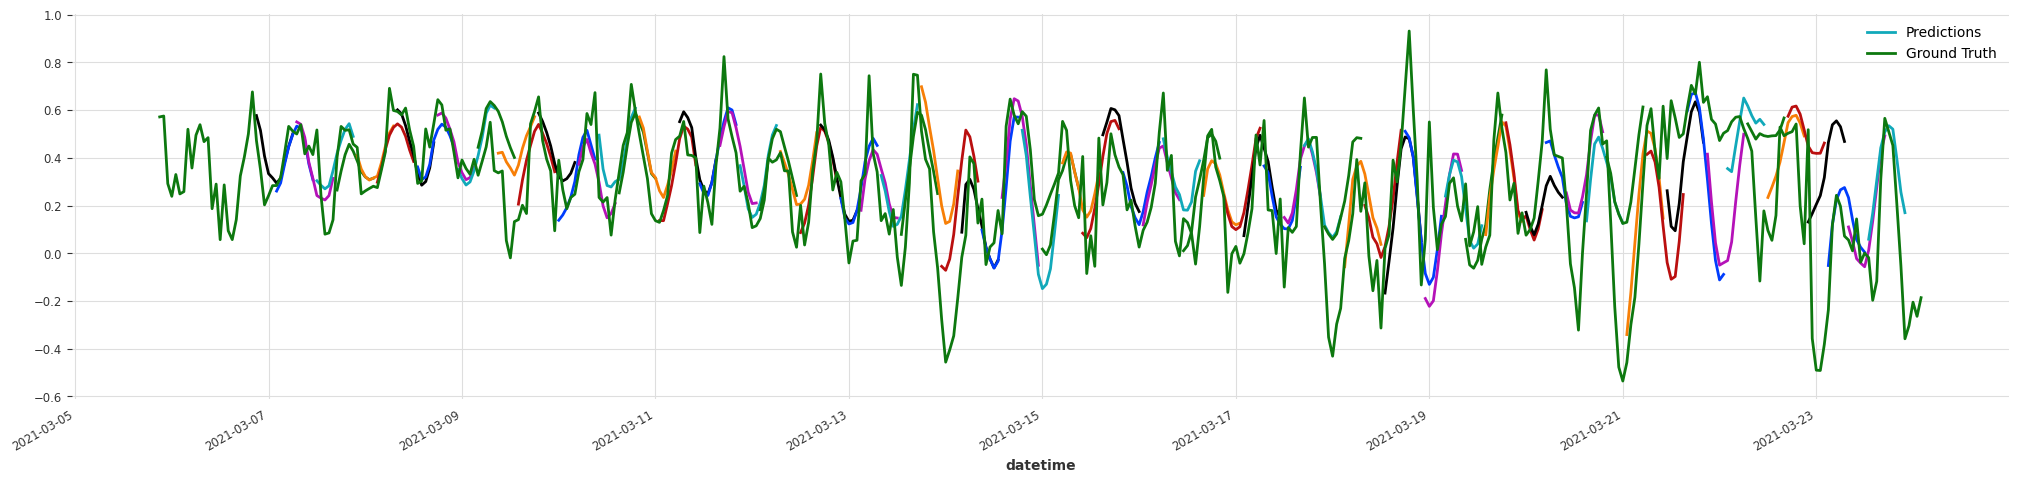

In [121]:
plt.figure(figsize=(25,5))
print(f"==>> len(historics): {len(historics)}")
print(f"==>> len(dict_tss['val_tgt_timeseriess_piped']): {len(dict_tss['val_tgt_timeseriess_piped'])}")
for i, (val_pred, val_gt) in enumerate(zip(historics, dict_tss['val_tgt_timeseriess_piped'])):
    # val_pred.plot(label='Predictions')
    print(f"==>> len(val_pred): {len(val_pred)}")
    print(f"==>> len(val_gt): {len(val_gt)}")

    for j, seq in enumerate(val_pred):
        seq.plot(label='Predictions')
        # if j < 10:
        #     seq.plot(label='Predictions')
        # else:
        #     break

    val_gt.plot(label='Ground Truth')
    break

# Only keep the first legend item
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()



In [104]:
from darts.metrics import mape, mse

model.backtest(
    series=dict_tss['val_tgt_timeseriess_piped'], 
    # past_covariates=dict_tss['val_cov_timeseriess_piped'],
    historical_forecasts=historics,
    stride=eval_stride,
    reduction=np.mean,
    retrain=False,
    verbose=True,
    metric=[mape, mse],
)



[array([2.23285068e+02, 4.78749002e-02]),
 array([7.09229617e+01, 2.02799342e-02]),
 array([5.19449621e+01, 1.83682959e-02]),
 array([10.05490108,  0.01087596])]

### Train and Eval loop

In [ ]:
import time
import json

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau

from darts.models import (
    BlockRNNModel, NBEATSModel, RandomForest, 
    LightGBMModel, XGBModel, LinearRegressionModel, TFTModel, TransformerModel
)

import wandb
wandb.login()



def init_model(config):

    '''Returns model instance, based on the config.'''

    model = config.model

    # for torch models
    optimizer_kwargs = {}
    try:
        optimizer_kwargs['lr'] = config.lr
    except:
        optimizer_kwargs['lr'] = 1e-3
    
    pl_trainer_kwargs = {
    'max_epochs': 20,
    'accelerator': 'gpu',
    'devices': [0],
    'callbacks': [EarlyStopping(monitor='val_loss', patience=5, mode='min')],
    #'logger': WandbLogger(log_model='all'),
    }

    schedule_kwargs = {
        'patience': 2,
        'factor': 0.5,
        'min_lr': 1e-5,
        'verbose': True
    }


    if model == 'xgb':

        try:
            xgb_kwargs = {
            'n_estimators': config.n_estimators,
            'max_depth': config.max_depth,
            'learning_rate': config.learning_rate,
            'min_child_weight': config.min_child_weight,
            'objective': config.objective,
            'reg_lambda': config.reg_lambda,
            'early_stopping_rounds': 10
            }
        except:
            xgb_kwargs ={}

        model = XGBModel(lags=config.n_lags,
                            lags_future_covariates=[0],
                            add_encoders=config.datetime_encoders, 
                            output_chunk_length=config.n_ahead, 
                            likelihood=config.liklihood,
                            random_state=42,
                            **xgb_kwargs
                            )
    
    elif model == 'lgbm':

        
        try:
            lightgbm_kwargs = {
            'n_estimators': config.n_estimators,
            'max_depth': config.max_depth,
            'learning_rate': config.learning_rate,
            'min_child_weight': config.min_child_weight,
            'num_leaves': config.num_leaves,
            'objective': config.objective,
            'min_child_samples': config.min_child_samples}

        except:
            lightgbm_kwargs = {}
        
        model = LightGBMModel(lags=config.n_lags,
                            lags_future_covariates=[0],
                            add_encoders=config.datetime_encoders,
                            output_chunk_length=config.n_ahead,
                            likelihood=config.liklihood,
                            random_state=42,
                            **lightgbm_kwargs
                            )

    elif model == 'rf':

        rf_kwargs = {
            'n_estimators': config.n_estimators,
            'max_depth': config.max_depth,
            'min_samples_split': config.min_samples_split,
            'min_samples_leaf': config.min_samples_leaf,
            }

        
        
        model = RandomForest(lags=config.n_lags,
                            lags_future_covariates=[0],
                            add_encoders=config.datetime_encoders,
                            output_chunk_length=config.n_ahead,
                            random_state=42,
                            **rf_kwargs
                            )


    elif model == 'nbeats':

        try:
            nbeats_kwargs = {
                'batch_size': config.batch_size,
            }

        except:
            nbeats_kwargs = {} 

        model = NBEATSModel(
                        input_chunk_length=config.n_lags,
                        output_chunk_length=config.n_ahead,
                        add_encoders=config.datetime_encoders,
                        likelihood=config.liklihood,
                        pl_trainer_kwargs=pl_trainer_kwargs,
                        optimizer_kwargs=optimizer_kwargs,
                        lr_scheduler_cls=ReduceLROnPlateau,
                        lr_scheduler_kwargs=schedule_kwargs,
                        random_state=42,
                        **nbeats_kwargs
                    )

    
    elif model == 'gru':


        try:
            rnn_kwargs = {
                'hidden_dim': config.hidden_dim,
                'n_rnn_layers': config.n_rnn_layers,
                'batch_size': config.batch_size,
                'dropout': config.dropout,
            }
        except:
            rnn_kwargs = {}

        model = BlockRNNModel(  
                        model = 'GRU',
                        input_chunk_length=config.n_lags,
                        output_chunk_length=config.n_ahead,
                        add_encoders=config.datetime_encoders,
                        likelihood=config.liklihood,
                        pl_trainer_kwargs=pl_trainer_kwargs,
                        optimizer_kwargs=optimizer_kwargs,
                        lr_scheduler_cls=ReduceLROnPlateau,
                        lr_scheduler_kwargs=schedule_kwargs,
                        random_state=42,
                        **rnn_kwargs
                    )
        

    elif model == 'tft':

        try:
            transformer_kwargs = {
                'hidden_size': config.hidden_dim,
                'lstm_layers': config.n_rnn_layers,
                'batch_size': config.batch_size,
                'dropout': config.dropout,
                'num_attention_heads': config.num_attention_heads,
            }
        except:
            transformer_kwargs = {}

        
        model = TFTModel(
                        input_chunk_length=config.n_lags,
                        output_chunk_length=config.n_ahead,
                        add_encoders=config.datetime_encoders,
                        likelihood=config.liklihood,
                        pl_trainer_kwargs=pl_trainer_kwargs,
                        optimizer_kwargs=optimizer_kwargs,
                        lr_scheduler_cls=ReduceLROnPlateau,
                        lr_scheduler_kwargs=schedule_kwargs,
                        random_state=42,
                        **transformer_kwargs
                    
                    )
        
    elif model == 'transformer':


        try:
            transformer_kwargs = {
                'd_model': config.d_model,
                'nhead': config.nhead,
                'num_encoder_layers': config.num_encoder_layers,
                'num_decoder_layers': config.num_decoder_layers,
                'batch_size': config.batch_size,
                'dropout': config.dropout,
                'num_attention_heads': config.num_attention_heads,
            }
        except:
            transformer_kwargs = {}

        model = TransformerModel(
                        input_chunk_length=config.n_lags,
                        output_chunk_length=config.n_ahead,
                        add_encoders=config.datetime_encoders,
                        likelihood=config.liklihood,
                        pl_trainer_kwargs=pl_trainer_kwargs,
                        optimizer_kwargs=optimizer_kwargs,
                        lr_scheduler_cls=ReduceLROnPlateau,
                        lr_scheduler_kwargs=schedule_kwargs,
                        random_state=42,
                    )
    return model


def train_loop(model, dict_tss, config):
    print("Training model...")
    start = time.time()

    config.use_past_cov = model.supports_past_covariates and config.use_past_cov
    config.use_future_cov = model.supports_future_covariates and config.use_future_cov

    try:
        model.fit(
            series=dict_tss['train_tgt_timeseriess_piped'], 
            past_covariates=dict_tss['train_cov_timeseriess_piped'] if config.use_past_cov else None, 
            future_covariates=dict_tss['train_cov_timeseriess_piped'] if config.use_future_cov else None,
            val_series=dict_tss['val_tgt_timeseriess_piped'], 
            val_past_covariates=dict_tss['val_cov_timeseriess_piped']
        )
    except:
        model.fit(
            series=dict_tss['train_tgt_timeseriess_piped'], 
            past_covariates=dict_tss['train_cov_timeseriess_piped'] if config.use_past_cov else None, 
            future_covariates=dict_tss['train_cov_timeseriess_piped'] if config.use_future_cov else None,
        )

    model.fit(dict_tss['train'])
    end = time.time()
    runtime = end - start
    return model, runtime


def train_eval(config):
    wandb.init(project="Portland_tuning")
    wandb.config.update(config_run)

    config = wandb.config

    print("Getting data...")

    dict_tss = prepare_timeseries(df, config=config, pipe=True)
    model = init_model(config)
    model, runtime = train_loop(model, dict_tss)

    print("Evaluating model...")
    predictions, score = eval_loop(model, dict_tss)

    wandb.log({'test_score': score})
    wandb.log({'runtime': runtime})
    wandb.log({'predictions': predictions})

    wandb.finish()


########################################################################################
# Sweep 
########################################################################################

sweeps = 20

models = [
    'rf',
    'xgb', 
    'gru', 
    'lgbm',  
    'nbeats',
    #'tft'
]

for model in models:
    # place holder initialization of config file (will be updated in train_eval_light()
    config_run = {
        'spatial_scale': 'City',
        'temp_resolution': 60,
        'location': 'East Portland',
        'model': model,
        'horizon_in_hours': 24,
        'lookback_in_hours': 24,
        'boxcox': True,
        'liklihood': None,
        'weather': True,
        'holiday': True,
        'datetime_encodings': False,
    }
    
    with open(f'sweep_configurations/config_sweep_{model}.json', 'r') as fp:
        sweep_config = json.load(fp)                  

    sweep_config['name'] = model + 'sweep' + config_run['spatial_scale'] + '_' + config_run['location'] + '_' + str(config_run['temp_resolution'])

    sweep_id = wandb.sweep(sweep_config, project="WattCast_tuning")
    wandb.agent(sweep_id, train_eval, count=sweeps)


